In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/affective-exercise1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


# Affective Computing - Programming Assignment 1




#### Objective

The objective of the exercise is to build a facial expression recognition system. The system includes face preprocessing, feature extraction and classification. In the exercise, you will learn how to preprocess a facial expression image, extract features from an image or a video, and classify a video into a category.

Specifically, the region of interest (i.e., facial image) is extracted using face tracking, face registration and face crop functions.  Basic spatiotemporal features (i.e., LBP-TOP features) are extracted using LBP-TOP. For classificaiton of the extracted features Support Vector Machine (SVM) classifiers are trained. 50 videos from 5 participants are used to train the emotion recognition, using spatiotemporal features. The rest of the data (50 videos) are used to evaluate the performances of the trained recognition system.

#### Database
The original facial expression data is a sub-set of eNTERFACE (acted facial expression), from ten actors acting **happy** and **sadness** behaviors. The used dataset in the exercise includes 100 facial expression samples.

<!---#### Help-->
<!--- The data and toolbox files used in this exercise can be found in the Affective Computing course webpage (see the Noppa system).
-->

<!---In the exercise, you should know that some basic python libries (numpy, scikit-image, scipy, pyploy, sklearn) before the programming. If you have questions, send your question to us:
* [Henglin.Shi@oulu.fi](mailto:Henglin.Shi@oulu.fi)
* [Yante.Li@oulu.fi](mail.Yante.Li@oulu.fi)-->

<!---Use the following website to help the usage of python libries.
* numpy: http://www.numpy.org/
* skimage: https://scikit-image.org/
* scipy: https://www.scipy.org/
* matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html
* sklearn: http://scikit-learn.org/stable/
    * sklearn.svm: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    * skealrn.metrics.confusion_matrix: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html-->

## Task 1. Face preprocessing

In this part, you are supposed to process a face image. There are three subtasks you need to do:
* **Task 1.1.** Detect face and facial landmarks using the [`DLib`](http://dlib.net/) library.
* **Task 1.2.** You are asked to perform a face registration task using a set of fixed landmarks from a standard model, and extract face from the registered image.
* **Task 1.3.** Visualize your result using subplots.

### Task 1.1. Extract facial landmarks <font color='red'>(1 point)</font>
**Steps**:
1. Load the example image *example_img.jpg*, using the [`plt.imread()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imread.html) function for example.
2. As a sanity check visualize the image to see what you are working with.
3. Initialize a face detector and a face landmarks detector. We have provide the code of this part, please learn to use them.
4. Detect the face
5. Detect the face landmarks
6. Transfrom the detected result to a 2-D numpy array by using the provided `shape2points` function from the *face_lib.py*.
7. Visualize the landmarks with the image

*Here is an example for facial landmarks extraction: http://dlib.net/face_landmark_detection.py.html (Note that this examples assumes multiple faces in the image. The images here only have a single sample, and no loop is required.)*



In [18]:
# Loading required libraries
import dlib
import numpy as np
import matplotlib.pyplot as plt
from face_lib import shape2points

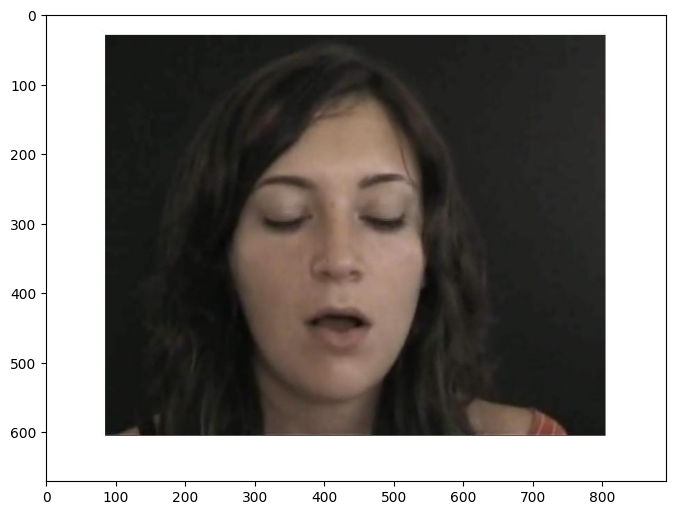

In [19]:
# 1. Load example_img.jpg, using plt.imread()
ex_img = plt.imread('/content/example_img.jpg')

# 2. Visualize the image using plt.imshow()
plt.figure(figsize=(8, 8))
plt.imshow(ex_img)

plt.show()

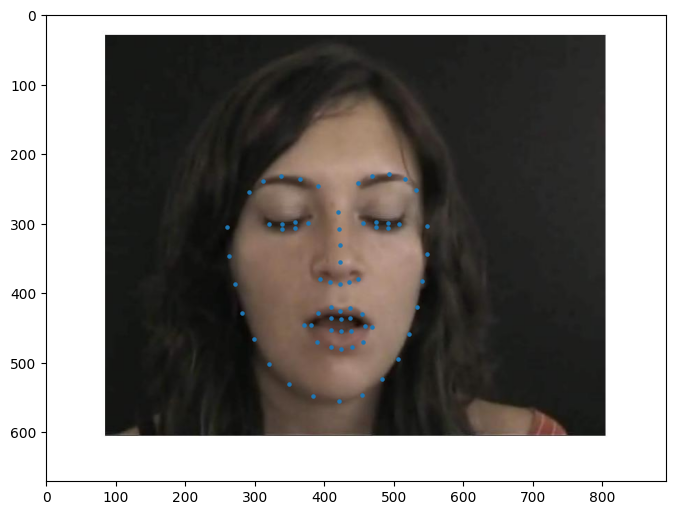

In [20]:
# 3. Initializing face detector and shape predictor
detector = dlib.get_frontal_face_detector()
#the shape predictor is a neural network that is loaded from the .dat file
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 4. Detect face, return rectangles, each rectangle corresponds to one face.
# You need to fill the missing argument of this function
dets = detector(ex_img, 1)

# 5. Extract the shape of the face in the first rectangle (using the first element of the rectangles variable)
img_shape = predictor(ex_img, dets[0])

# 6. Extract facial landmarks from shape by calling the shape2points() function.
img_landmarks = shape2points(img_shape)

# 7. Visualize the landmarks (keypoints) by first plotting the image and then using plt.scatter() for the landmarks
plt.figure(figsize=(8, 8))

plt.imshow(ex_img)
Xs, Ys = zip(*img_landmarks)
plt.scatter(Xs, Ys, s=5)

plt.show()

### Task 1.2. Face normalization <font color='red'>(1 point)</font>
**Steps**:
1. Load the landmark position of a standard face model. We provide these positions in a csv file, and also the code block to read these positions.
2. Calculate the transformation between your detected landmarks position and the standard face model landmark positions using the [`skimage.transform.PolynomialTransform()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.PolynomialTransform) class and its *estimate()* methods.
    1. Instantiate a PolynomialTransform object by calling transform.PolynomialTransform()
    2. Call its estimate() method to calculate the transformation between the two sets of points. The manual of this method can be found in the same page which introduced of this class.
3. Transform the example image using the calculated transformation to register (map) the example image into a space of the standard face model. You can use the [`skimage.transform.warp()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp) function to perform this.
4. Crop the face from the registered face using the standard face model landmarks. The cropping function is provided in the *face_lib.py*, you can directly use it after importing.
5. Also extract the face from the example image using your detected landmarks.
<!---Use **cropFace** to crop the facial image from the background. For details on the **cropFace** function, please read the function in **exercise1Lib.py**. Usually, we have to do the face registration to remove the subject characteristics. To do a  face registration, firstly you need a set of landmarks of a standard face model. Then you calculate the transformation between you detected landmarks and the standard landmarks. Last you apply the transformation on your example image/-->

In [21]:
# 1. Load the landmark position of the standard face model from a csv file and store them in standard_model
# 1. Load the landmark position of the standard face model from a csv file and store them in standard_model
def load_landmarks_from_csv(
    file_name: str
) -> np.ndarray:
    """
    Reads landmarks from a csv file.
    Arguments
    file_name : A csv file with landmarks
    Returns
    numpy array with the landmarks
    """
    standard_model = np.zeros((68, 2))
    with open(file_name, "r") as f:
        for i, line in enumerate(f.readlines()):
            line_split = line.replace("\n", "").split(",")
            standard_model[i] = [float(value) for value in line_split]
    # Multiply with 500 (width) as the landmarks are normalized
    standard_model *= 500
    return standard_model

standard_model = load_landmarks_from_csv("mean.csv")

<!---**Then you need to calculate the transformation using [`skimage.transform.PolynomialTransform()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.PolynomialTransform)**. This class has several methods, expecially, you need to use the **estimate()** method to calculate the transformation between two sets of points. **Registering the example face** by transforming the example image into the standard model space, using [`skimage.transform.warp()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp) and you calculated transformation. **Cropping the original example image according to the detected landmarks, and the registered image according to the standard face mode. **-->

In [22]:
from skimage import transform
from face_lib import crop_face

# 2. Calculating the transorfmation between the two set of points
# 2.1 Instantiating a PolynomialTransform() transform function
polyTrans = transform.PolynomialTransform()

# 2.2 Calculating the transformation by calling the estimate() method.
#     You do not need to retuern any value after calling this methods,
#     because the transformation parameter is store in the object you instantiated after calling this methods.
polyTrans.estimate(standard_model, img_landmarks)

# 3. Warp the example image using the transform.warp() function
warp_img = transform.warp(ex_img, polyTrans)

# 4. Crop the face from registered image using the provided crop_face function.
crop_warp = crop_face(warp_img, standard_model)

# 5. Croping the face from the example image using detected landmarks.
crop_original = crop_face(ex_img, img_landmarks)


### Task 1.3. Display result <font color='red'>(2 points)</font>
Here you are asked to draw a figure with 3 x 2 subplots using [`matplotlib.pyplot.subplots()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html). Please read the manual of it and also the [`matplotlib.pyplot`](https://matplotlib.org/api/pyplot_api.html).

Each of the subplots should have the following images:
* subplot [0, 0]: the original example image and detected landmarks.
* subplot [1, 0]: the face cropped from the example image.
* subplot [2, 0]: the histogram of the face cropped from the example.

*As an example, the three subplots are given above.* Then you need to implement:
* subplot [0, 1]: the registered face image.
* subplot [1, 1]: the face cropped from the registered face image.
* subplot [2, 1]: the histogram of the face cropped from the registered face image.



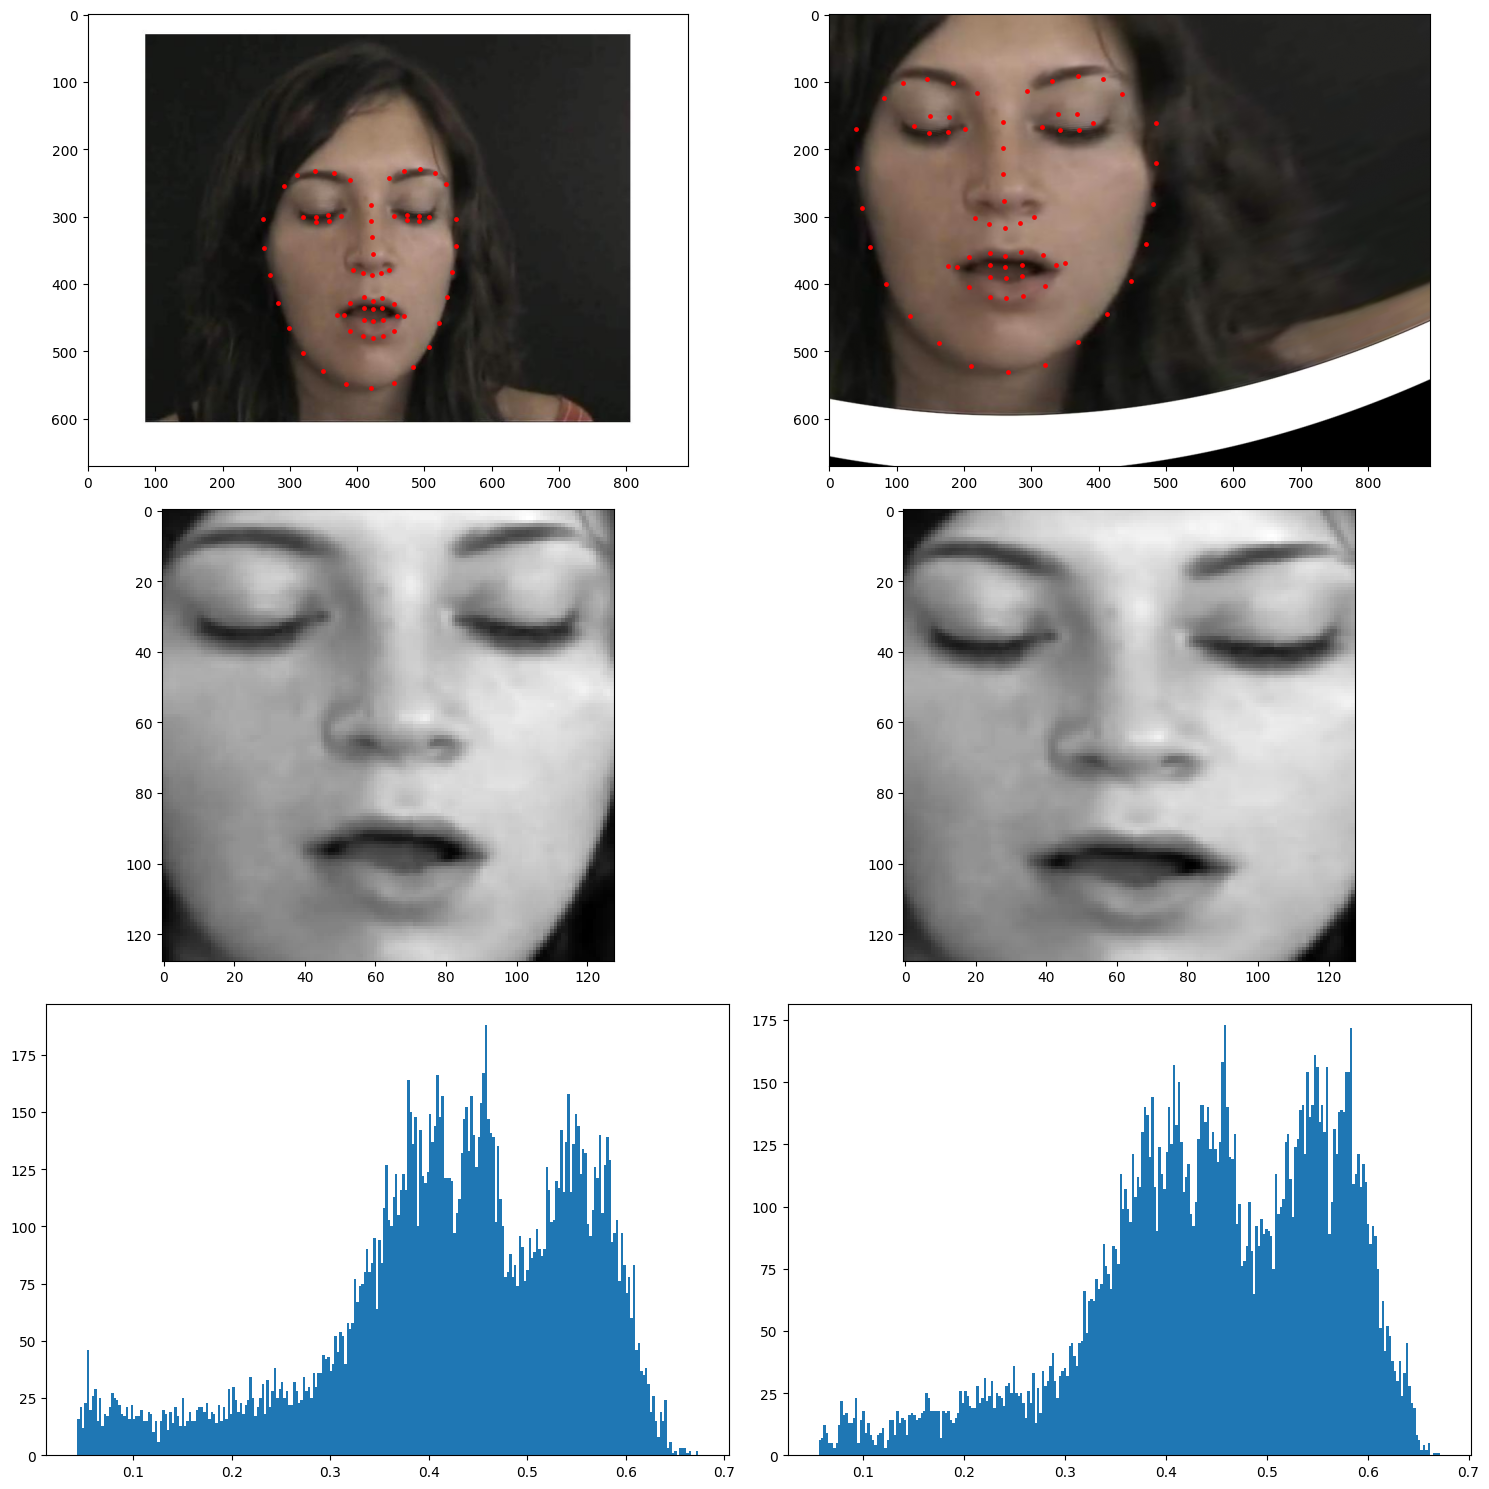

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import img_as_ubyte

# Constructing figure with 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# subplot [0,0]: show the original example image
ax[0, 0].imshow(ex_img)


# Placing detected landmarks on subplot [0,0], we provide an exmaple to do this.
ax[0, 0].scatter(img_landmarks[:, 0], img_landmarks[:, 1], c="red", s=6)


# subplot [1,0]: show the face cropped from the example image.
ax[1, 0].imshow(crop_original, "gray")


# subplot [2,0]: show the histogram of the face cropped from the example image.
ax[2, 0].hist(crop_original.ravel(), bins=256)

# subplot [0,1]: show the registered image
ax[0, 1].imshow(warp_img)


# place the model landmarks on the registered image
ax[0, 1].scatter(standard_model[:, 0], standard_model[:, 1], c="red", s=6)


# subplot [1,1]: show the face cropped from the registered image
ax[1, 1].imshow(crop_warp, "gray")


# subplot [2,1]: show the histogram of the face cropped from the registered image.
ax[2, 1].hist(crop_warp.ravel(), bins=256)

fig.tight_layout()
plt.show()

### Question 1. What is the difference between the cropped example image (subplot [1, 0]) and the cropped registered image (subplot [1, 1])? What is the mapping between the images called?
*Hints: Look at the two images very closely, the change is very subtle. The code may also provide hints for the transformation name.*

### Your answer:

I assume that if we compare the landmarks of the original image and the warped, transformed image, we would notice that the warped landmarks are tend to be more symmetric. To be more specific, the original cropped image (subplot [1, 0]) is more natural and human-like, however, the the arped cropped image (subplot [1, 1]) is more toward a specific standard template for face.
This mapping is called (geometrical) transformation; or polynomial transformation as mentioned in the code.

### Question 2. What is the purpose of the operation asked in the previous question, why is it done?

### Your answer:

Because, in image-related tasks, we don't always have symmetrical, clear or high quality pictures of faces. People’s faces vary in size and shape, and sometimes the face might be tilted or not straight in the photo. So for an easier analysis and comparison, we use transformation. In this way, all faces are adjusted to a standard and consistent shape.

## Task 2. Feature extraction <font color='red'>(2 points)</font>
Here you are asked to extract LBP (Local Binary Pattern) features. LBP has been widely used in face recognition, facial expression recognition and texture classification.
Here you will use the [`skimage.feature.local_binary_pattern()`](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.local_binary_pattern) function to extract the LBP features. Steps are explained below.

**Steps**:
1. Define the LBP parameters. Before doing this, carefully read the documentation.
    1.  P: Number of neighbours, set P = 8
    2.  R: Radius of circle, set R = 1.0
    3.  LBP methods: set it as 'nri_uniform'

2. Extract the LBP face by calling the *skimage.feature.local_binary_pattern()* function

3. Calculate the histogram of the LBP face
    1. Caculate the histogram of the LBP face
    2. Normalize the histogram to make the histogram's sum one one (dividing each element by the sum of the histogram).

4. Visualize the result using two subplots.
    1. Draw the LBP face on the left side. Use the *cmap="gray"* parameter
    2. Draw the normalized histogram on the right side, but using *.stem()* function rather *.plot()* for this time.

<ipython-input-47-03d7916a1b18>:23: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem(hist, use_line_collection=True)


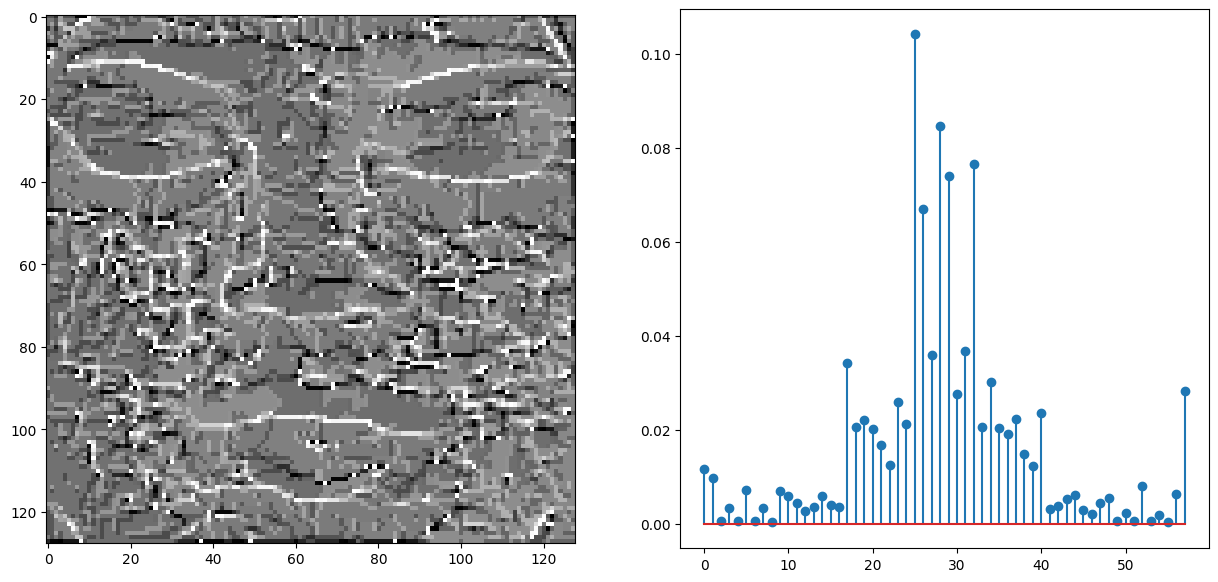

In [47]:
from skimage.feature import local_binary_pattern

# 1. Define the parameters to extract LBP features in (8, 1) neighborhood:
#    1.1 Set the number of neighbour P = 8
#    1.2 Set the radius if circir R = 1.0
#    2.3 Set the method as "nri_uniform"
P = 8
R = 1.0
method = "nri_uniform"

# 2. Extract the LBP face using local_binary_pattern() with the defined parameters
LBP_face = local_binary_pattern(crop_warp, P, R, method)


# 3. Calculate the histogram of the LBP face (58 bins). Normalize the histogram's sum to one
hist, bins = np.histogram(LBP_face, bins=58, density=True)
hist /= hist.sum()


# 4. Visualize your result.
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(LBP_face, cmap="gray")
ax[1].stem(hist, use_line_collection=True)

plt.show()




### Question 3. Why is feature extraction (e.g. LBP) used, why can't we simply classify the (raw) images in their original domain?

### Your answer:

Because it simplifies images by removing unimportant and unneccessary data. And it focuses on more important features of the image. So getting rid of noise and highlighting crucial features can actually enhance the accuracy of our model. Also, it makes the classification process more robust and efficient. And the model can perform better when seeing new data and not get overfitted.

## Task 3. Feature Classification

For feature classification the SVM (Support Vector Machine) will be utilized. See the documentation for [`sklearn.svm.SVC()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Mainly you will use its two methods: **fit()** to training the classifier and **predict()** to use the classifer for classification. There are following three subtasks you need to complete:
* Task 3.1. Load data
* Task 3.2. Train classifiers
* Task 3.3. Evaluate classifiers



### Task 3.1. Load data <font color='red'>(1.5 points)</font>
Firstly, you need to read *.mat* files using python. You can use the [`scipy.io.loadmat()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html#scipy.io.loadmat) function to read *.mat* file. In the provided **Task3_data.mat** file, different data are packed by different dictionaries which are list below:
* training_data
* testing_data
* training_class
* testing_class

For example if you would like to load the *training_data* from the file, you can use **scipy.io.loadmat('Task3_data.mat')['training_data']**

Print the shapes of data for a sanity check.



In [53]:
import scipy.io as sio

# Loading data using scipy.io.loadmat(), or sio.loadmat
mdata = sio.loadmat("Task3_data.mat")

# Load 'training_data'
sample_train = mdata["training_data"]

# Load 'testing_data'
sample_test = mdata["testing_data"]

# Load 'training_class'
class_train = mdata["training_class"]
class_train = np.squeeze(class_train)

# Load 'testing_class'
class_test = mdata["testing_class"]
class_test = np.squeeze(class_test)

#Print the shapes from each of the data splits
print(sample_train.shape)
print(sample_test.shape)
print(class_train.shape)
print(class_test.shape)


(50, 708)
(50, 708)
(50,)
(50,)


### Question 4. The training data (*sample_train*) has a shape of $(50, 708)$. What do the numbers refer to? What is 50 and what is 708?

### Your answer:

50 means the number of samples or data, 708 is number of features. So each row is a data which we give to a model all at once and each column is a feature of that data.

### Task 3.3. Train SVM classifiers <font color='red'>(0.5 points)</font>
Use the **sklearn.svm** library to train Support Vector Machine (SVM) classifiers. The *sample_train* and *sample_test* matrices contain the calculated LBP-TOP features for the training and testing sets, respectively. The block size for LBP-TOP used for training and testing data are 2x2x1. The *label_test* group vector contains the class of samples: 1 = happy, 2 = sadness, corresponding to the rows of the training data matrices.

**Steps**:
1.  Construct an SVM classifier object using a linear kernel. See [`sklearn.svm.SVC()`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

2.  Use the [`fit()`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit) method and the *sample_train* and *label_train* to train your classifier.

In [60]:
from sklearn import svm
# 1. Initializing an SVM classifier, using linear kernel
svm_classifier = svm.SVC(kernel='linear')

# 2. Use the classifier to fit your training data
svm_classifier.fit(sample_train, class_train)

SVC(kernel='linear')

### Task 3.3. Evaluate your classifiers <font color='red'>(2 points)</font>
**Steps**:
1. Use your trained classifer to classify the *sample_train* and *sample_test*, using the [`predict()`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict) method.
2. Calculate the classification accuracies when classifying the *sample_train* and *sample_test*, respectively. The correct class labels corresponding with the rows of the training and testing data matrices are in the variables *label_train* and *label_test*, respectively.
3. Calculate the confusion matrices when evaluating both the dataset by using [`sklearn.metrics.confusion_matrix()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).


In [61]:
# 1. Predict the training data and testing data.
train_pred = svm_classifier.predict(sample_train)
test_pred = svm_classifier.predict(sample_test)


# 2. Calculate the accuracies of your prediction on training data and testing data, respectively.
#    2.1 Calculate the accuracy when classifying the training data
print("Training data accuracy: ")
train_acc = np.sum(train_pred == class_train) / class_train.shape[0]
print(train_acc)

#    2.2 Calculate the accuracy when classifying the test data
print("Testing data accuracy: ")
test_acc = np.sum(test_pred == class_test) / class_test.shape[0]
print(test_acc)

from sklearn.metrics import confusion_matrix

# 3. Print/Draw the confusion matrix using sklearn.metrics.confusion_matrix
#    3.1 Calculate the confusion matrix when classifying the training data
print("Training data confusion matrix: ")
train_confmatrix = confusion_matrix(class_train, train_pred)
print(train_confmatrix)


#    3.2 Calculate the confusion matrix when classifying the testing data
print("Testing data confusion matrix: ")
test_confmatrix = confusion_matrix(class_test, test_pred)
print(test_confmatrix)



Training data accuracy: 
0.88
Testing data accuracy: 
0.72
Training data confusion matrix: 
[[20  5]
 [ 1 24]]
Testing data confusion matrix: 
[[25  0]
 [14 11]]


### Question 5. Compare the classification results from train data and test data. Which one achieves a better accuracy? Why?

### Your answer:

Training data has gained a better accuracy and this might be a sign of overfitting. because the number of data is low and model cannot generalize well in testing phase.

### Question 6. Look at the confusion matrix of test data. In which class did the classifier perform better, the happiness or sadness?

### Your answer:

as mentioned, 1 is happy, 2 is sad. So column 0 shows the predictions with label happy, and column 1 shows the predictions with label sad.

**in test predictions:**

25 data were happy and predicted happy

14 data were happy and predicted sad

11 data were sad and predicted sad

0 data were sad and predicted happy


as we can see, the classifier performed better on 'happiness' class. Because 25 data were labeled as 'happiness' and model managed to predict them as happy and gained a 100% recall.
